# 讀標註完的

28 28
18
{'15': [6, 13, 8, 18], '14': [15, 14, 13, 26], '13': [27, 10, 21, 35], '12': [50, 19, 21, 28], '11': [74, 18, 36, 36], '21': [113, 17, 37, 38], '22': [152, 8, 25, 39], '23': [178, 14, 24, 27], '24': [204, 17, 15, 17], '25': [221, 17, 12, 12]}


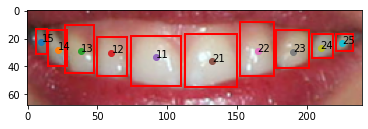

In [25]:
from os import listdir
import json 
from pathlib import Path
import matplotlib.pyplot as plt
import io
import cv2
import numpy as np 
from PIL import Image
import random as rd
from app.lib.Polygon import Polygon
Dir_path=Path('./app/TrainData/labeled')
files = listdir(str(Dir_path/'image'))

all_path=[]
all_mask_path=[]

colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()


for f in files:
    f=Path(f)
    if f.suffix!='.png':
        print(f)
        continue

    fullpath=Dir_path/'image'/f
    maskpath=Dir_path/'mask'/f'{f.stem}.json'

    all_path.append(str(fullpath.resolve()))
    all_mask_path.append(str(maskpath.resolve()))

    
        
print(len(all_path) ,len(all_mask_path))

all_mask=[]
#for path,maskpath in rd.shuffle(zip(all_path,all_mask_path)):

idx=rd.randrange(len(all_mask_path))
print(idx)
idx=17

path=all_path[idx]
maskpath=all_mask_path[idx]
fig=cv2.imread(path)

with open(maskpath) as f:
    data=json.load(f)
#print(data)
all_mask.append(data)
plt.imshow(cv2.cvtColor(fig,cv2.COLOR_RGB2BGR))

anns={}
for i in range(len(data['mask'])):
    mask=np.array(data['mask'][i])
    if data['label'][i]!=-1:
        currentAxis=plt.gca()
        plt.text(np.mean(mask[:,0]), np.mean(mask[:,1]), data['label'][i])
        plt.scatter(np.mean(mask[:,0]), np.mean(mask[:,1]))

        x, y, w, h=Polygon(mask).bbox
        anns[data['label'][i]]=[ x, y, w, h]
        currentAxis.add_patch( plt.Rectangle((x,y),w,h,fill=False,edgecolor='r',linewidth=2))

print(anns)
#2023-09-19-14-35-44.png

# 產生CoCo資料格式

In [26]:
from BuildCoCoDataset import BuildCoCoDataset

BuildCoCoDataset(0.8)

build(./app/TrainData/labeled/train.json,['0065.png', '2023-09-19-14-32-02.png', '0273.png', '2023-09-14-17-14-38.png', '2023-09-19-14-28-53.png', '2023-09-19-14-42-47.png', '2023-09-19-14-45-24.png', '2023-09-19-14-36-41.png', '2023-09-19-14-39-24.png', '2023-09-19-14-35-44.png', '0071.png', '2023-09-19-14-32-26.png', '2023-09-19-14-31-07.png', '0059.png', '2023-09-19-14-38-40.png', '0111.png', '2023-09-19-14-44-22.png', '0298.png', '2023-09-19-14-42-01.png', '2023-09-19-14-34-13.png', '2023-09-19-14-31-39.png', '2023-09-19-14-40-02.png'])


## 驗證CoCo

{'name': '2023-09-19-14-31-39.png', 'anns': [[32, 27, 17, 20, 2], [53, 25, 21, 18, 1], [76, 27, 28, 16, 5], [107, 31, 19, 11, 6]]}


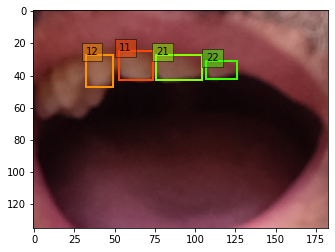

In [27]:
import json
import os
import random as rd
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()


def load_img_ann(ann_path=str(Dir_path/"train.json")):
    """return [{img_name, [ (x, y, h, w, label), ... ]}]"""
    with open(ann_path) as fp:
        root = json.load(fp)
    img_dict = {}
    for img_info in root['images']:
        img_dict[img_info['id']] = {'name': img_info['file_name'], 'anns': []}
    for ann_info in root['annotations']:
        img_dict[ann_info['image_id']]['anns'].append(
            ann_info['bbox'] + [ann_info['category_id']])
        
    cate_dict={}

    for cate in root["categories"]:
        cate_dict[cate["id"]]=cate["name"]

    return img_dict, cate_dict


def show_img_ann(img_info,cate_dict):
    from PIL import Image
    #from dldemos.nms.show_bbox import draw_bbox
    print(img_info)

    """with open(str(Dir_path/"train.json")) as fp:
        root = json.load(fp)
    categories = root['categories']
    category_dict = {int(c['id']): c['name'] for c in categories}
"""
    img_path = Dir_path/"image"/img_info['name']
    img = Image.open(img_path)

    currentAxis = plt.gca()

    plt.imshow(img)
    for ann in img_info['anns']:
        x, y, w, h, c = ann
        x1, y1, x2, y2 = x, y, x + w, y + h
        #draw_bbox(img, (x1, y1, x2, y2), 1.0, text=category_dict[ann[4]])
        currentAxis.add_patch(plt.Rectangle((x,y),w,h,
                                            fill=False,
                                            edgecolor=colors[c],
                                            linewidth=2))
        currentAxis.text(x, y, cate_dict[c],
                         bbox={'facecolor': colors[c], 'alpha': 0.5})

    #img.save('work_dirs/tmp.jpg')




    plt.show()



img_dict, cate_dict = load_img_ann()
keys = list(img_dict.keys())
show_img_ann(img_dict[rd.choice(keys)],cate_dict)

#

In [28]:
from app.lib.Polygon import Polygon
import matplotlib.pyplot as plt
import numpy as np



def read(ann_path):
    x_data=[]
    y_data=[]
    img_path={}
    with open(ann_path) as fp:
        root = json.load(fp)

    for img in root["images"]:
        img_path[img['id']]=str(Dir_path/"image"/img['file_name'])

    for ann in root["annotations"]:
        mask_pol=Polygon(np.array(ann['segmentation']).reshape(-1,2))
        try:
            img= cv2.imread(img_path[ann['image_id']])
        except:
            print(ann)
            continue
        h,w,d=img.shape
        img=cv2.resize(img,(512,512) )
        #plt.subplot(211)
        #plt.imshow(img)
        x=np.array(img)
        

        
        mask=np.zeros([h,w], np.uint8)
        try:
            cv2.fillPoly(mask,[mask_pol.points],1)
        except:
            print("can't fill",mask_pol.points)

        mask = Image.fromarray(mask)
        mask= mask.resize((512,512))
        #plt.subplot(212)
        #plt.imshow(mask)
        mask=np.array(mask)
        mask=np.expand_dims(mask,axis=-1)

        #x=mask

        x=np.concatenate((x,mask),axis=2 )



        y_data.append(ann['category_id'])
        x_data.append(x)
    return np.array(x_data),np.array(y_data)



In [29]:
from tensorflow.keras import layers, models, utils,callbacks
# one-hot encoding
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
import tensorflow as tf




In [30]:
train_path=str(Dir_path/"train.json")
test_path=str(Dir_path/"test.json")
with open(train_path) as fp:
        root = json.load(fp)
        num_class =  len(root['categories'])
        all_class = [a['name'] for a in root['categories']]


img_size = 256


class_map = {cls: i for i, cls in enumerate(all_class)} 
print(num_class,class_map)




11 {'null': 0, '11': 1, '12': 2, '13': 3, '14': 4, '21': 5, '22': 6, '23': 7, '24': 8, '25': 9, '26': 10}


In [31]:



train_x,train_y=read(train_path)
test_x,test_y=read(test_path)

input_shape=train_x[0].shape

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, 
                                                  test_size=0.2, # 80% : 20%
                                                  random_state=5566)
train_x.shape, val_x.shape, train_y.shape, val_y.shape


train_y = utils.to_categorical(train_y, 
                               num_classes=len(class_map))
val_y = utils.to_categorical(val_y, 
                             num_classes=len(class_map))
test_y = utils.to_categorical(test_y, 
                              num_classes=len(class_map))


print(train_x.shape, val_x.shape, train_y.shape, val_y.shape)
print(train_y.shape, val_y.shape, test_y.shape)

(128, 512, 512, 4) (33, 512, 512, 4) (128, 11) (33, 11)
(128, 11) (33, 11) (47, 11)


In [32]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf.test.gpu_device_name()
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Build Model

In [33]:
from models import vgg16_model,GoogLeNet_model

model=GoogLeNet_model(input_shape,num_class)

In [34]:
model.compile(loss='categorical_crossentropy',
            #   loss=tf.keras.losses.CategoricalCrossentropy(),
              
              optimizer='adam',
              metrics=['accuracy']
              )



In [35]:
weight_saver = callbacks.ModelCheckpoint('seg.h5', 
                                         save_best_only=True)
earlystop = callbacks.EarlyStopping(patience=20)

logs = model.fit(train_x, train_y,
                 batch_size=6,
                 epochs=1000,
                 validation_data=(val_x, val_y),
                 callbacks = [weight_saver, earlystop]
                 )

Epoch 1/1000
22/22 [==============================] - 5s 119ms/step - loss: 11.2894 - accuracy: 0.1016 - val_loss: 2.3587 - val_accuracy: 0.0303
Epoch 2/1000
22/22 [==============================] - 1s 58ms/step - loss: 2.3176 - accuracy: 0.0859 - val_loss: 2.3561 - val_accuracy: 0.0606
Epoch 3/1000
22/22 [==============================] - 1s 58ms/step - loss: 2.2963 - accuracy: 0.1172 - val_loss: 2.3156 - val_accuracy: 0.0303
Epoch 4/1000
22/22 [==============================] - 1s 46ms/step - loss: 2.2936 - accuracy: 0.1016 - val_loss: 2.3526 - val_accuracy: 0.0303
Epoch 5/1000
22/22 [==============================] - 1s 59ms/step - loss: 2.3077 - accuracy: 0.1484 - val_loss: 2.2934 - val_accuracy: 0.1818
Epoch 6/1000
22/22 [==============================] - 1s 58ms/step - loss: 2.3292 - accuracy: 0.1484 - val_loss: 2.2639 - val_accuracy: 0.1818
Epoch 7/1000
22/22 [==============================] - 1s 45ms/step - loss: 2.2777 - accuracy: 0.1016 - val_loss: 2.2979 - val_accuracy: 0.03

### Training logs

min_loss_epoch:  6
val loss  2.2638983726501465
val acc 0.1818181872367859


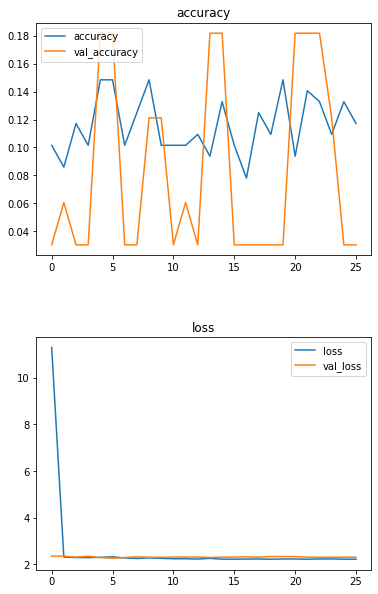

In [38]:
history = logs.history
min_loss_epoch = np.argmin(history['val_loss'])
print('min_loss_epoch: ', min_loss_epoch+1)
print('val loss ', history['val_loss'][min_loss_epoch])
print('val acc', history['val_accuracy'][min_loss_epoch])

plt.subplot(211)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')

plt.subplot(212)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=2, 
                    #wspace=0.2, 
                    hspace=0.35)

In [37]:
from models import vgg16_model,GoogLeNet_model
import json

with open('./app/TrainData/labeled/train.json') as fp:
        root = json.load(fp)
        num_class =  len(root['categories'])
        all_class = [a['name'] for a in root['categories']]



class_map = {cls: i for i, cls in enumerate(all_class)} 
print(num_class,class_map)

model=vgg16_model((512, 512, 1),num_class)
model.load_weights('seg.h5')


model.compile(loss='categorical_crossentropy',
            #   loss=tf.keras.losses.CategoricalCrossentropy(),
              
              optimizer='adam',
              metrics=['accuracy']
              )
l,a=model.evaluate(test_x, test_y)
#print(f'loss: {l} - accuracy: {a}' )

11 {'null': 0, '11': 1, '12': 2, '13': 3, '14': 4, '21': 5, '22': 6, '23': 7, '24': 8, '25': 9, '26': 10}


ValueError: Layer count mismatch when loading weights from file. Model expected 16 layers, found 58 saved layers.

In [ ]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')# 或是版本比較低的tensorflow :


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
